In [9]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import torch
from pymultifracs.simul import mrw
from mvmd_python import mvmd
from scipy.stats import pearsonr

In [3]:
# # Parameters
# num_samples = 32768  # Length of the signal (number of samples)
# num_channels = 20    # Number of channels

# H = 0.8  # Hurst exponent (controls the fractality)
# lam = np.sqrt(0.7)  # Lambda, intermittency parameter
# L = 1024  # Integral scale
# sigma = 1  # Standard deviation of noise

# # 1. Generate a shared low-frequency component
# t = np.linspace(0, 1, num_samples)
# shared_freq_signal = np.sin(2 * np.pi * 0.01 * t)  # Low frequency sinusoid

# # 2. Generate different frequency components for each channel
# signal = np.zeros((num_samples, num_channels))

# for i in range(num_channels):
#     if i < 10:  # Use MRW to introduce multifractality in some channels
#         signal[:, i] = mrw(shape=(num_samples, 1), H=H, lam=lam, L=L, sigma=sigma).squeeze()
#     else:  # Use a random frequency component for the other channels
#         noise = np.random.randn(num_samples) * 0.2
#         signal[:, i] = shared_freq_signal + noise


In [10]:
# Parameters
T = 32768
t = np.linspace(0, 1, T)
num_channels = 8
signal = np.zeros((T, num_channels))

# Shared sine
shared_sine = np.sin(2 * np.pi * 0.01 * t)

# 1. Channels 0–1: Shared low-frequency sine + noise
for ch in [0, 1]:
    noise = np.random.normal(0, 0.2, T)
    signal[:, ch] = shared_sine + noise

# 2. Channels 2–3: MRW (with noise)
for ch in [2, 3]:
    signal[:, ch] = mrw(T, H=0.8, lam=np.sqrt(0.7), L=1024, sigma=1.0)

# 3. Channels 4–5: Mixed sine + MRW + noise
for ch in [4, 5]:
    mrw_part = mrw(T, H=0.8, lam=np.sqrt(0.7), L=1024, sigma=1.0)
    noise = np.random.normal(0, 0.2, T)
    signal[:, ch] = shared_sine + mrw_part + noise

# 4. Channels 6–7: Clean MRW (no noise)
for ch in [6, 7]:
    signal[:, ch] = mrw(T, H=0.8, lam=np.sqrt(0.7), L=1024, sigma=1.0)


In [11]:
num_channels = signal.shape[1]
T = signal.shape[0]
offset = 5

channel_colors = ['blue'] * 2 + ['red'] * 2 + ['green'] * 2 + ['orange'] * 2

fig = make_subplots(
    rows=num_channels, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.02,
)

for i in range(num_channels):
    fig.add_trace(
        go.Scatter(
            x=np.arange(T),
            y=signal[:, i] + i * offset,
            mode='lines',
            name=f"Channel {i+1}",
            line=dict(width=1, color=channel_colors[i])
        ),
        row=i + 1, col=1
    )
    # Hide y-axis tick labels
    fig.update_yaxes(
        showticklabels=False,
        row=i + 1, col=1
    )

fig.update_layout(
    height=100 * num_channels,
    width=1000,
    title="Multichannel Signal (Colored by Group & Vertically Spaced)",
    template="plotly_white",
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    ),
    
    # Add global y-axis label using annotation
    annotations=[
        dict(
            text="Amplitude ",
            xref="paper", yref="paper",
            x=-0.06, y=0.5,
            showarrow=False,
            textangle=-90,
            font=dict(size=14)
        )
    ]
)

fig.update_xaxes(title_text="Time", row=num_channels, col=1)
fig.show()


In [5]:
# fig = make_subplots(
#     rows=num_channels, cols=1,
#     shared_xaxes=True,
#     subplot_titles=[f"Channel {i+1}" for i in range(num_channels)],
#     vertical_spacing=0.005
# )

# for i in range(num_channels):
#     fig.add_trace(
#         go.Scatter(
#             y=signal[:, i],
#             mode='lines',
#             line=dict(width=1),
#             name=f"Channel {i+1}"
#         ),
#         row=i+1, col=1
#     )


# fig.update_layout(
#     height=50 * num_channels,  # Dynamically scale height
#     width=900,
#     title="Multichannel Signal (MRW and Sinusoidal Mix)",
#     showlegend=False,
#     template="plotly_white"
# )

# fig.show()


In [12]:
alpha = 2000  # Balancing parameter
tau = 0.  # Time-step of dual ascent
K = 4  # Number of modes to recover
DC = 0  # No DC component
init = 1  # Initialize frequencies uniformly
tol = 1e-7  # Convergence tolerance
max_N = 50  # Maximum iterations

u, u_hat, omega = mvmd(signal, alpha, tau, K, DC, init, tol, max_N)

Iteration 1, uDiff: 1.0000000022204e-07
Iteration 2, uDiff: 102973.1484375
Iteration 3, uDiff: 233.25241088867188
Iteration 4, uDiff: 0.6897096037864685
Iteration 5, uDiff: 0.0027862931601703167
Iteration 6, uDiff: 1.795748721633572e-05
Iteration 7, uDiff: 1.4452322716351773e-07


In [14]:

fig = make_subplots(
    rows=K, cols=1,
    shared_xaxes=True,
    subplot_titles=[f"Mode {k + 1}" for k in range(K)],
    vertical_spacing=0.03
)

legend_added = set()

for k in range(K):  
    for channel in range(num_channels):  
        show_legend = channel not in legend_added
        fig.add_trace(
            go.Scatter(
                y=u[k, :, channel].numpy(),
                mode='lines',
                name=f"Channel {channel + 1}",
                showlegend=show_legend
            ),
            row=k + 1,
            col=1
        )
        legend_added.add(channel)

fig.update_layout(
    height=300 * K,  
    width=900,
    title_text="Time-Domain Decomposed Modes Across Channels",
    template="plotly_white",
    legend_title="Channels",
    xaxis_title="Time (samples)",
    yaxis_title="Amplitude"
)

fig.show()


ValueError: x and y must have same first dimension, but have shapes (8,) and (32768,)

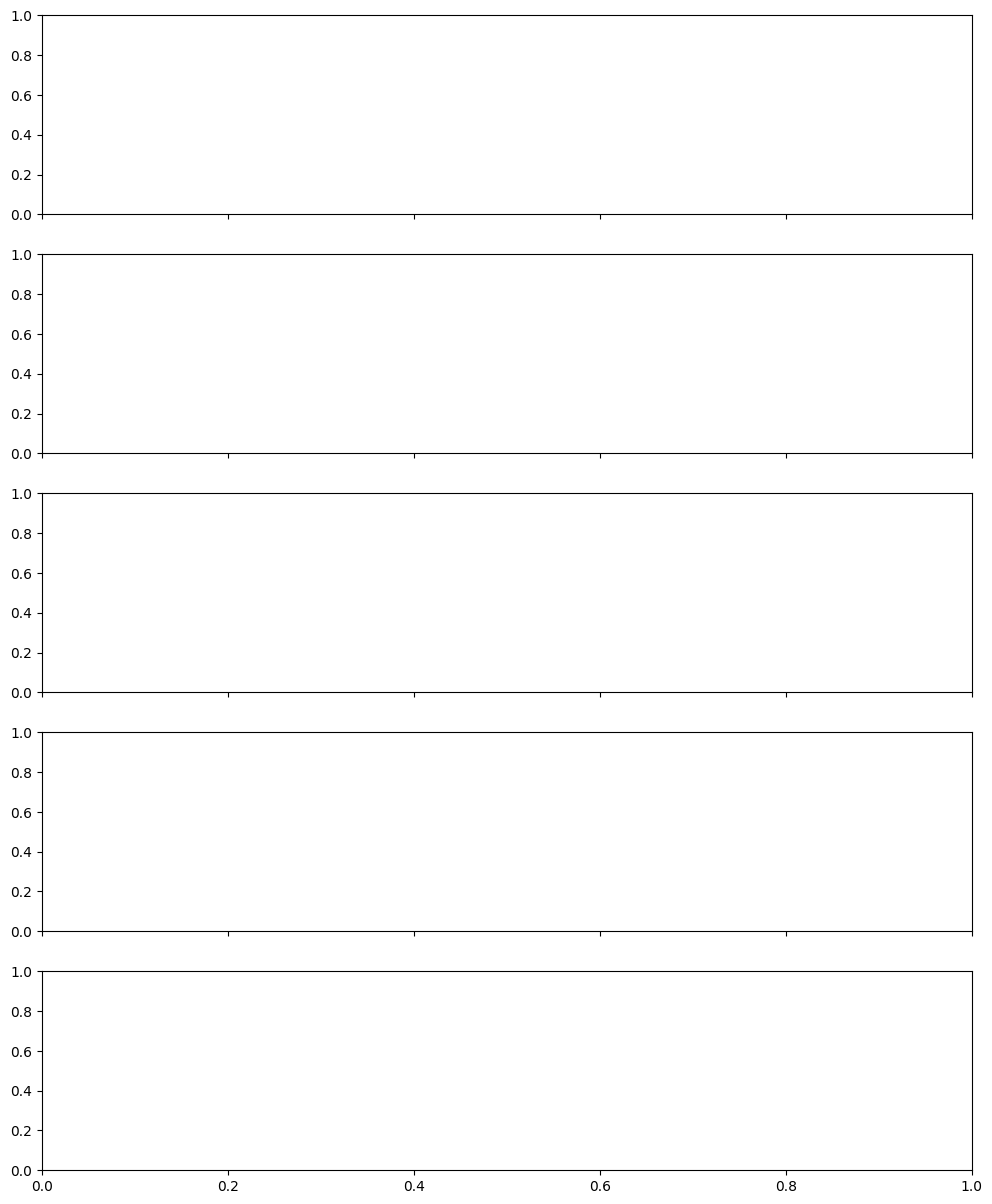

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters
K = u.shape[0]  # Number of modes
T = u.shape[1]  # Number of time points
num_channels = u.shape[2]  # Number of channels

# Time vector (x-axis)
x = np.arange(T)

# Channel group (for simplicity, we'll start with Channels 1 and 2)
channel_group = [0, 1]  # Group 1: Channel 1 and Channel 2

# Create subplots: Rows for modes and the original signal, columns for channel group
fig, axs = plt.subplots(K + 1, 1, figsize=(12, 3 * (K + 1)), sharex=True)

# Colors for each group of channels
colors = plt.cm.tab10.colors

# Row 1: Original signal for Channel 1 and Channel 2
for ch in channel_group:
    axs[0].plot(x, signal[:, ch], label=f"Channel {ch + 1}", color=colors[ch % len(colors)], linewidth=0.8)

axs[0].set_title("Original Signal (Channels 1 and 2)")
axs[0].set_ylabel("Original Signal")
axs[0].grid(True)

# Plot each mode (from u₁ to uₖ)
for k in range(K):
    for ch in channel_group:
        axs[k + 1].plot(x, u[k, :, ch].numpy(), label=f"Channel {ch + 1}", color=colors[ch % len(colors)], linewidth=0.8)

    axs[k + 1].set_ylabel(f"u{k + 1}")
    axs[k + 1].grid(True)

# Set x-axis label for the last row
axs[K].set_xlabel("Time (samples)")

plt.tight_layout()
plt.show()


In [15]:
u_hat_abs = torch.abs(u_hat).numpy()  # or .cpu().numpy() if it's on GPU
num_freqs = u_hat_abs.shape[0]              # Define frequency axis

# Create one interactive plot per mode
for k in range(K):
    fig = go.Figure()

    for channel in range(num_channels):
        fig.add_trace(go.Scatter(
            x=np.arange(num_freqs),
            y=u_hat_abs[:, k, channel],
            mode='lines',
            name=f'Channel {channel + 1}'
        ))

    fig.update_layout(
        title=f"Spectrum of Mode {k + 1} for All Channels",
        xaxis_title="Frequency",
        yaxis_title="Magnitude",
        legend_title="Channels",
        height=500,
        width=900
    )

    fig.show()


In [16]:
fig = go.Figure()

# Convert omega to real part
omega_real = omega.real.numpy()

for k in range(K):
    fig.add_trace(go.Scatter(
        y=omega_real[:, k],
        mode='lines',
        name=f"Mode {k + 1}"
    ))

fig.update_layout(
    title="Center Frequencies (Omega) for Each Mode",
    xaxis_title="Iteration",
    yaxis_title="Frequency (Hz)",
    template="plotly_white",
    legend_title="Modes",
    height=500,
    width=900
)

fig.show()


In [17]:
K, T, C = u.shape
mode_corr_matrix = np.zeros((K, K))

for k1 in range(K):
    for k2 in range(K):
        corr_sum = 0
        for c in range(C):
            x = u[k1, :, c].numpy()
            y = u[k2, :, c].numpy()
            corr, _ = pearsonr(x, y)  # Pearson correlation
            corr_sum += corr
        mode_corr_matrix[k1, k2] = corr_sum / C  # Average over channels

# Plot
labels = [f"Mode {k+1}" for k in range(K)]
fig = px.imshow(
    mode_corr_matrix,
    x=labels,
    y=labels,
    color_continuous_scale="RdBu_r",
    zmin=-1,
    zmax=1,
    title="Cross-Correlation Matrix Between Modes (Averaged over Channels)"
)
fig.update_layout(
    width=600,
    height=600,
    xaxis_title="Mode",
    yaxis_title="Mode"
)
fig.show()


In [ ]:
""" 🧮 Step-by-step: Compute correlation between Mode 1 and Mode 2 for 4 channels

For channel 1:
    corr(u1[:, 0], u2[:, 0])

For channel 2:
    corr(u1[:, 1], u2[:, 1])

For channel 3:
    corr(u1[:, 2], u2[:, 2])

For channel 4:
    corr(u1[:, 3], u2[:, 3])

✅ Total: 4 correlation values
(one per channel, comparing the same channel in both modes)

Then:
    Average the 4 values to get a single correlation score between Mode 1 and Mode 2
 """